In [1]:
#データとモジュールの読み込み
import numpy as np
import pandas as pd
# 機械学習のライブラリ．今回は線形回帰LinearRegressionを動かす．
# LinearRegressionはsklearnのlinear_modelモジュールの中にあるので，次のようにインポートする
from sklearn.linear_model import LinearRegression
from google.colab import drive
drive.mount('/content/drive') # google driveをマウント（＝Colabから使えるようにする）
# Google Colabの場合
d_train = pd.read_csv("/content/drive/My Drive/PBL2025/omni2_selected_2000_2024.csv") # 訓練データを読み込む
d_test = pd.read_csv("/content/drive/My Drive/PBL2025/omni2_selected_2025H1_Dst99999.csv") # テストデータを読み込む

Mounted at /content/drive


In [2]:
#指定した列だけ取り出す
xlist = [ 'Year', 'Month', 'Day_of_month','Hour[h]', 'B_mag[nT]','Bx_GSE[nT]', 'By_GSM[nT]','Bz_GSM[nT]', 'T_proton[K]', 'N_proton[cm^-3]', 'V_sw[km/s]',
         'Flow_pressure[nPa]', 'E_field[mV/m]', 'Sunspot_num', 'f10.7[sfu]', 'Lyman_alpha[W/m^2]']
         #colabの場合はReturnで改行できる
ylist = ['Dst[nT]']
x_train = d_train[xlist]
y_train = d_train[ylist]
x_test = d_test[xlist]
y_test = d_test[ylist]

In [3]:
#訓練データに新しい特徴量を追加
x_train['Bz_lag6'] = x_train['Bz_GSM[nT]'].shift(6)
x_train['Bz_diff6'] = x_train['Bz_GSM[nT]'] - x_train['Bz_GSM[nT]'].shift(6)
x_train['Bz_ma3'] = x_train['Bz_GSM[nT]'].rolling(3).mean()
x_train['Ef_lag6'] = x_train['E_field[mV/m]'].shift(6)
x_train['Ef_diff6'] = x_train['E_field[mV/m]'] - x_train['E_field[mV/m]'].shift(6)
x_train['Ef_ma3'] = x_train['E_field[mV/m]'].rolling(3).mean()
#テストデータに追加
#Add new feature
x_test['Bz_lag6'] = x_test['Bz_GSM[nT]'].shift(6)
x_test['Bz_diff6'] = x_test['Bz_GSM[nT]'] - x_test['Bz_GSM[nT]'].shift(6)
x_test['Bz_ma3'] = x_test['Bz_GSM[nT]'].rolling(3).mean()
x_test['Ef_lag6'] = x_test['E_field[mV/m]'].shift(6)
x_test['Ef_diff6'] = x_test['E_field[mV/m]'] - x_test['E_field[mV/m]'].shift(6)
x_test['Ef_ma3'] = x_test['E_field[mV/m]'].rolling(3).mean()

In [4]:
x_train = x_train.bfill() #ひとつ前のデータで補間
x_test = x_test.bfill()

In [5]:
# 分割前に必ず定義
n_train = len(x_train)
n_valid = int(0.2 * n_train)  # 検証データの数．ラベル付きデータ数n_trainの2割を検証データにする
n_train = n_train - n_valid # 訓練データ数を計算し直す．検証データ以外全てなので，全体（n_train)からn_validationを引く
x_valid = x_train[n_train:] # 現在のX_train_numの後半2割 = 前半8割以降
x_train = x_train[:n_train] # 現在のX_train_numの前半8割．再代入する（変数名を使い回す）

# 目標値も同じように分割する
y_valid = y_train[n_train:]
y_train = y_train[:n_train]

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(
    learning_rate=0.06, max_iter=300,
    max_depth=None, l2_regularization=1.0,
    early_stopping=True, random_state=42
)

# 学習
hgb.fit(x_train_scaled, y_train.values)

# 予測
y_pred = hgb.predict(x_valid_scaled)

# MSE
mse = mean_squared_error(y_valid, y_pred)
print("MSE:", mse)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE: 225.14947759147103


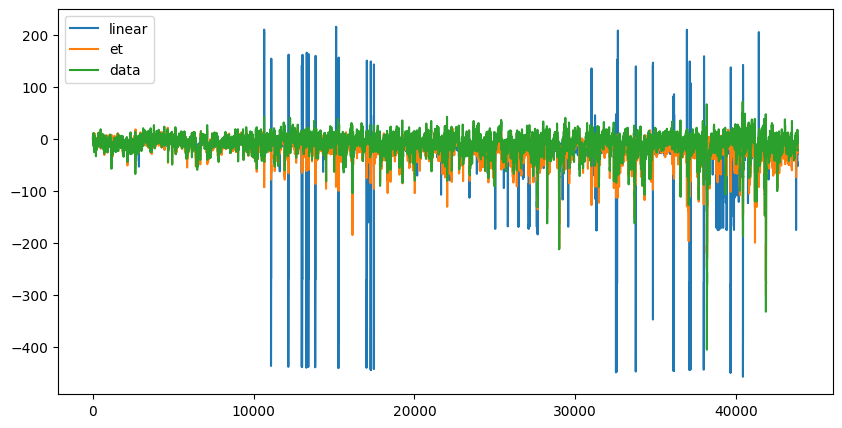

In [8]:
#モジュールの読み込み
from sklearn.linear_model import LinearRegression

# 通常の線形モデルの作成と予測
lr = LinearRegression()# LinearRegressionのインスタンスの作成
lr.fit(x_train, y_train)# 上で作ったオブジェクトの学習
y_pred_valid_lr = lr.predict(x_valid)#　検証データに対する予測

import matplotlib.pyplot as plt
xplot = np.arange(n_valid) # 0,1,2...n_valid-1のような配列になる
plt.figure(figsize=(10,5)) #figsize => (x,y)の図のサイズ
plt.plot(xplot,y_pred_valid_lr,label="linear") #label; 凡例の文字
plt.plot(xplot,y_pred,label="hgb") #label; 凡例の文字
plt.plot(xplot,y_valid,label="data")
plt.legend() #凡例を表示
plt.show()

In [9]:
#テストデータの予測と提出
y_pred_test = hgb.predict(x_test_scaled)
np.savetxt('/content/drive/My Drive/PBL2025/y_pred_hgb.csv', y_pred_test,delimiter=',')